✅ Auto-selected the latest FASTA file：.\250428_H5_HA_Avian_ALL_38270.fasta
✅ Loaded 196 location-to-country entries.
📋 Total raw FASTA header sequences: 33993. Successfully extracted locations: 33981. Error: 12.
⚠️ The headers of the virus strains that caused errors are listed below:
  - >EPI_ISL_3031133 | A_mallard_Denmark_12946-11_2020-10-26 | A / H5N2 | 2020-10-26
  - >EPI_ISL_18458053 | A_herring_gull_Latvia_287263_21VIR8325-5_2021 | A / H5N1 | 2021-05-30
  - >EPI_ISL_18788590 | A_European_herring_gull_Denmark_17519-1.02_2021 | A / H5N8 | 2021-02-28
  - >EPI_ISL_18788591 | A_Northern_gannet_Denmark_06250-1.02_2022 | A / H5N1 | 2022-06-29
  - >EPI_ISL_18788588 | A_European_herring_gull_Denmark_24453-1.01_2021 | A / H5N1 | 2021-11-05
  - >EPI_ISL_18788589 | A_Canada_goose_Denmark_07348-1.02_2022 | A / H5N1 | 2022-09-12
  - >EPI_ISL_18788586 | A_barnacle_goose_Denmark_25242-1.01_2021 | A / H5N1 | 2021-12-09
  - >EPI_ISL_18788587 | A_common_buzzard_Denmark_00526-1.01_2022 | A / H5N1 | 

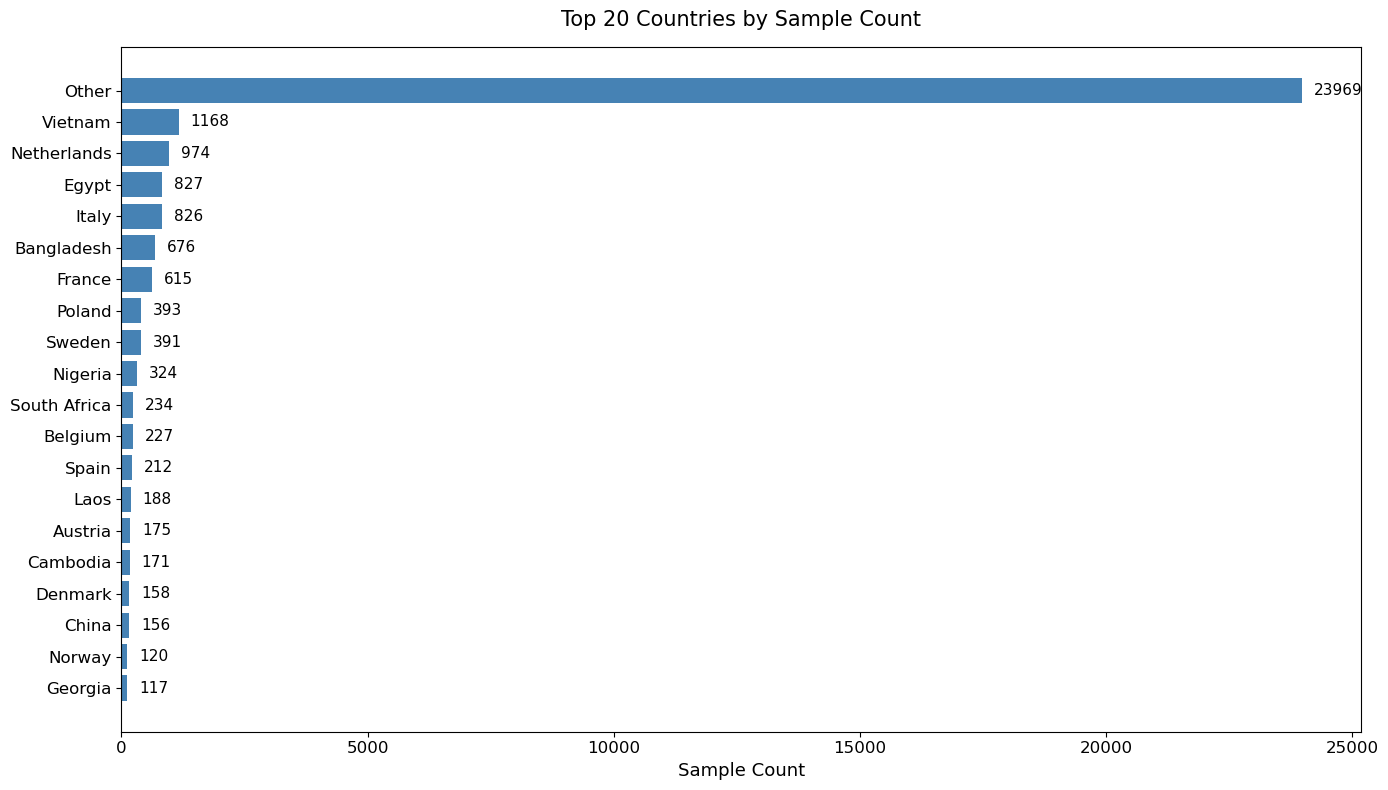

🖼️ Saved bar chart with sample count annotations:top20_countries_sample_count.png


In [ ]:
# 📓 Notebook: AIV HA Country Analysis + gpt-3.5 / gpt-4o 自動切換 + 限流自動重試 + 進度條 + 即時保存 + 中斷續跑

# --- 1. Load required packages ---
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import re
import os
import time
import json
import datetime
import zipfile
import glob
from collections import Counter, defaultdict
from tqdm import tqdm

# --- 2. User configuration ---
fasta_folder = "."  # 或指定資料夾路徑
fasta_files = sorted(glob.glob(os.path.join(fasta_folder, "*.fasta")), key=os.path.getmtime, reverse=True)

if fasta_files:
    fasta_path = fasta_files[0]
    print(f"✅ Auto-selected the latest FASTA file：{fasta_path}")
else:
    raise FileNotFoundError("❗ No .fasta files found. Please check the directory.")
location_to_country_path = "location_to_country_ISO_3166_1.json"

# --- 3. Initialize location-country mapping ---
if os.path.exists(location_to_country_path):
    with open(location_to_country_path, "r", encoding="utf-8") as f:
        location_to_country = json.load(f)
    print(f"✅ Loaded {len(location_to_country)} location-to-country entries.")
else:
    location_to_country = {}
    print("⚡ Not found location_to_country_ISO_3166_1.json. Creating and saving an empty dictionary.")
    try:
        with open(location_to_country_path, "w", encoding="utf-8") as f:
            json.dump(location_to_country, f, ensure_ascii=False, indent=4)
        print(f"✅ Created and saved an empty {location_to_country_path}")
    except Exception as e:
        print(f"❌ Failed to save location_to_country_ISO_3166_1.json error: {e}.")

# --- 4. Parse location from FASTA headers ---
with open(fasta_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Extract only header lines (starting with '>')
headers = [line.strip() for line in lines if line.startswith(">")]
location_list = []
fail_count = 0
fail_headers = []

# Use regex to extract location name（The substring between the second and third slashes）
for header in headers:
    match = re.search(r"A/[^/]+/([^/]+)/", header)
    if match:
        location = match.group(1).strip()
        location_list.append(location)
    else:
        fail_count += 1
        fail_headers.append(header)
        
print(f"📋 Total raw FASTA header sequences: {len(headers)}. Successfully extracted locations: {len(location_list)}. Error: {fail_count}.")

# 📢 顯示error標頭清單
if fail_headers:
    print("⚠️ The headers of the virus strains that caused errors are listed below:")
    for fh in fail_headers:
        print(f"  - {fh}")

# --- 📂 5. Read location list ---
# 統計每個地名出現次數
location_counter = Counter(location_list)
total_samples = sum(location_counter.values())

# 轉成DataFrame並依照樣本數排序並儲存成CSV
location_df = pd.DataFrame(location_counter.items(), columns=["Location", "Count"]).sort_values(by="Count", ascending=False)
location_df.to_csv("location_list.csv", index=False)
print(f"📄 Saved location list to location_list.csv (Total of {len(location_df)} entries).")

# --- 🌍 6. Sample count by country
country_counter = defaultdict(int)
other_locations = defaultdict(int)
for loc, count in location_counter.items():
    country = location_to_country.get(loc, "Other")
    if country == "Other":
        other_locations[loc] += count
    country_counter[country] += count

country_df = pd.DataFrame(sorted(country_counter.items(), key=lambda x: x[1], reverse=True), columns=["Country", "Sample_Count"])

# 核對總樣本數一致性
assert country_df["Sample_Count"].sum() == total_samples, f"Inconsistent sample total!！Total: {country_df['Sample_Count'].sum()}. It should be: {total_samples}"

# 儲存國家統計CSV
country_df.to_csv("country_stat.csv", index=False)

# 📢 Task completion report
print(f"🏁 All country counting completed! Total number of successfully extracted locations: {total_samples}. Sum of country counts: {country_df['Sample_Count'].sum()} — Perfect match ✅")

# 📢 Recognition results
success_samples = total_samples - sum(other_locations.values())
fail_samples = sum(other_locations.values())

print(f"🌐 Successfully identified {success_samples} samples using ISO-3166-1 country codes. {fail_samples} samples could not be matched and were classified as 'Other'. Top 20 unmatched location names:")
if other_locations:
    # 取出樣本數最高的前20個未能辨識地名
    for loc, count in sorted(other_locations.items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"  - {loc}: {count}")

# --- 🖼️ 7. Generate bar chart of top 20 countries by sample count
country_df = pd.read_csv("country_stat.csv")

# 取前20名國家
top20_countries = country_df.head(20)

# 畫圖
plt.figure(figsize=(14, 8))
bars = plt.barh(top20_countries['Country'], top20_countries['Sample_Count'], color='steelblue')
plt.xlabel('Sample Count', fontsize=13)
plt.title('Top 20 Countries by Sample Count', fontsize=15, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()  # 最高的排最上面

# 在每個bar標上數值
for bar in bars:
    width = bar.get_width()
    plt.text(width + (0.01 * top20_countries['Sample_Count'].max()),  # 靠右微調
             bar.get_y() + bar.get_height()/2,
             f'{int(width)}', 
             va='center', ha='left', fontsize=11)

plt.tight_layout()

# 儲存成高解析PNG
plt.savefig("top20_countries_sample_count.png", dpi=600)
plt.show()

print("🖼️ Saved bar chart with sample count annotations:top20_countries_sample_count.png")